# ECSE 551 MP3 G17

## 定义常量、导入外部库和数据集、准备CUDA设备

In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import platform
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.benchmark.examples.spectral_ops_fuzz_test import DEVICE_NAMES
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold

# 设置设备
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# 设置训练的batch大小
THE_BATCH_SIZE = 32

# 检测操作系统并设置基础路径
if platform.system() == 'Windows':
    base_path = 'F:\\Personal_file\\work_area\\Study\\ECSE_551\\Project3\\DataSet'
    # 定义全局常量和文件路径
    TRAIN_PKL_FILE = os.path.join(base_path + '\\Train.pkl')
    TRAIN_LABEL_FILE = os.path.join(base_path + '\\Train_labels.csv')
    TEST_PKL_FILE = os.path.join(base_path + '\\Test.pkl')
    SUBMISSION_FILE = os.path.join(base_path + '\\Submission' + '-CNN-2' + '.csv')
else:
    base_path = os.path.join('/mnt/f/Personal_file/work_area/Study/ECSE_551/Project3/DataSet')
    TRAIN_PKL_FILE = os.path.join(base_path + '/Train.pkl')
    TRAIN_LABEL_FILE = os.path.join(base_path + '/Train_labels.csv')
    TEST_PKL_FILE = os.path.join(base_path + '/Test.pkl')
    SUBMISSION_FILE = os.path.join(base_path + '/Submission' + '-CNN-2' + '.csv')

print("Train PKL File Path:", TRAIN_PKL_FILE)
print("Train Label File Path:", TRAIN_LABEL_FILE)
print("Test PKL File Path:", TEST_PKL_FILE)
print("Submission File Path:", SUBMISSION_FILE)

Using device: cuda
Train PKL File Path: F:\Personal_file\work_area\Study\ECSE_551\Project3\DataSet\Train.pkl
Train Label File Path: F:\Personal_file\work_area\Study\ECSE_551\Project3\DataSet\Train_labels.csv
Test PKL File Path: F:\Personal_file\work_area\Study\ECSE_551\Project3\DataSet\Test.pkl
Submission File Path: F:\Personal_file\work_area\Study\ECSE_551\Project3\DataSet\Submission-CNN-2.csv


## 正式开始

### 尝试读取训练数据，并显示第一张图片

<class 'numpy.ndarray'>
Data dimensions: (1, 28, 28)


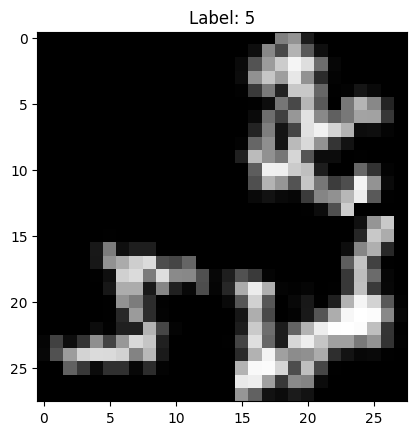

In [2]:
# 加载训练数据和标签
with open(TRAIN_PKL_FILE, 'rb') as file:
    train_data = pickle.load(file)

labels_df = pd.read_csv(TRAIN_LABEL_FILE)
labels_dict = dict(zip(labels_df['id'], labels_df['class']))
train_labels = [labels_dict.get(i + 1, 'Unknown') for i in range(len(train_data))]

# 检查数据结构
print(type(train_data))  # 查看数据类型
print("Data dimensions:", train_data[0].shape)  # 检查数据维度

# 显示第一张图片（假设是灰度图像）
plt.imshow(train_data[0].squeeze(), cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()


### 定义自定义数据集并准备数据

In [3]:
# 定义自定义数据集
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return image, label

# 创建数据集和数据加载器
train_dataset = CustomDataset(train_data, train_labels)

## CNN

### 定义 CNN 模型

In [4]:
# 定义 CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 1 * 1, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [5]:
# 定义扩展后的 CNN 模型
class ExtendedCNN(nn.Module):
    def __init__(self):
        super(ExtendedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 10)  # 10 个类别

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # 输出尺寸减半
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # 输出尺寸减半
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))  # 输出尺寸减半
        x = torch.relu(self.bn4(self.conv4(x)))             # 不进行池化，保持尺寸
        x = torch.relu(self.bn5(self.conv5(x)))             # 不进行池化，保持尺寸
        x = self.global_pool(x)                             # 全局平均池化到 1x1
        x = x.view(x.size(0), -1)                           # 展平张量
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## Transformer

In [11]:
# 定义 Vision Transformer 模型
class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, num_classes=10, embed_dim=768, depth=12, num_heads=12, mlp_dim=3072):
        super(VisionTransformer, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_dim = in_channels * patch_size * patch_size
        self.embed_dim = embed_dim

        # 图像切块
        self.patch_embeddings = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)

        # 位置编码
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

        # 分类标识符
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Transformer编码器层
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=mlp_dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # 分类头
        self.classifier = nn.Linear(embed_dim, num_classes)

        # 初始化参数
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.patch_embeddings.weight)
        nn.init.normal_(self.position_embeddings, std=0.02)
        nn.init.normal_(self.cls_token, std=0.02)
        nn.init.xavier_uniform_(self.classifier.weight)

    def forward(self, x):
        # x: [batch_size, in_channels, img_size, img_size]
        x = self.patch_embeddings(x)  # [batch_size, embed_dim, num_patches_sqrt, num_patches_sqrt]
        x = x.flatten(2)  # [batch_size, embed_dim, num_patches]
        x = x.transpose(1, 2)  # [batch_size, num_patches, embed_dim]

        # 扩展cls_token
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)  # [batch_size, 1, embed_dim]

        # 拼接cls_token和图像块
        x = torch.cat((cls_tokens, x), dim=1)  # [batch_size, num_patches + 1, embed_dim]

        # 添加位置编码
        x = x + self.position_embeddings  # [batch_size, num_patches + 1, embed_dim]

        # 输入Transformer编码器
        x = x.transpose(0, 1)  # [num_patches + 1, batch_size, embed_dim]
        x = self.encoder(x)  # [num_patches + 1, batch_size, embed_dim]
        x = x.transpose(0, 1)  # [batch_size, num_patches + 1, embed_dim]

        # 取出cls_token对应的输出
        x = x[:, 0, :]  # [batch_size, embed_dim]

        # 分类
        x = self.classifier(x)  # [batch_size, num_classes]
        return x

## 进行交叉验证训练和测试

### CNN交叉测试

In [8]:
# 交叉验证训练和测试
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=THE_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=THE_BATCH_SIZE, shuffle=False)

    model = ExtendedCNN().to(DEVICE)  # Move model to device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(15):  # Adjust the number of epochs as needed
        model.train()
        for images, labels in train_loader:
            images = images.to(DEVICE)  # Move data to device
            labels = labels.to(DEVICE)  # Move labels to device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE)  # Move data to device
                labels = labels.to(DEVICE)  # Move labels to device
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy:.2f}%")

Fold 1
Epoch 1, Validation Accuracy: 88.02%
Epoch 2, Validation Accuracy: 93.97%
Epoch 3, Validation Accuracy: 94.50%
Epoch 4, Validation Accuracy: 94.15%
Epoch 5, Validation Accuracy: 95.46%
Epoch 6, Validation Accuracy: 96.17%
Epoch 7, Validation Accuracy: 95.95%
Epoch 8, Validation Accuracy: 96.28%
Epoch 9, Validation Accuracy: 96.28%
Epoch 10, Validation Accuracy: 96.09%
Epoch 11, Validation Accuracy: 96.80%
Epoch 12, Validation Accuracy: 96.38%
Epoch 13, Validation Accuracy: 96.77%
Epoch 14, Validation Accuracy: 96.12%
Epoch 15, Validation Accuracy: 96.79%
Fold 2
Epoch 1, Validation Accuracy: 87.59%


KeyboardInterrupt: 

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
total_epochs_x = 15
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=THE_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=THE_BATCH_SIZE, shuffle=False)

    model = ExtendedCNN().to(DEVICE)  # Move model to device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs)

    # Train the model
    for epoch in range(total_epochs_x):  # Adjust the number of epochs as needed
        print(f"Epoch: {epoch + 1}")
        model.train()
        for images, labels in train_loader:
            images = images.to(DEVICE)  # Move data to device
            labels = labels.to(DEVICE)  # Move labels to device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # 在每个epoch结束后更新学习率
        scheduler.step()

        # 可选：打印当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr:.6f}")

        # Evaluate the model on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE)  # Move data to device
                labels = labels.to(DEVICE)  # Move labels to device
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f"Validation Accuracy: {accuracy:.2f}%")

Fold 1
Epoch: 1
Current Learning Rate: 0.000989
Validation Accuracy: 84.09%
Epoch: 2
Current Learning Rate: 0.000957
Validation Accuracy: 88.14%
Epoch: 3
Current Learning Rate: 0.000905
Validation Accuracy: 91.38%
Epoch: 4
Current Learning Rate: 0.000835
Validation Accuracy: 92.88%
Epoch: 5
Current Learning Rate: 0.000750
Validation Accuracy: 91.95%
Epoch: 6
Current Learning Rate: 0.000655
Validation Accuracy: 93.35%
Epoch: 7
Current Learning Rate: 0.000552
Validation Accuracy: 92.16%
Epoch: 8
Current Learning Rate: 0.000448
Validation Accuracy: 93.58%
Epoch: 9
Current Learning Rate: 0.000345
Validation Accuracy: 93.36%
Epoch: 10
Current Learning Rate: 0.000250
Validation Accuracy: 94.72%
Epoch: 11
Current Learning Rate: 0.000165
Validation Accuracy: 95.11%
Epoch: 12
Current Learning Rate: 0.000095
Validation Accuracy: 95.62%
Epoch: 13
Current Learning Rate: 0.000043
Validation Accuracy: 95.91%
Epoch: 14
Current Learning Rate: 0.000011
Validation Accuracy: 96.09%
Epoch: 15
Current Lear

KeyboardInterrupt: 

### Transformer交叉测试

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
total_epochs = 100
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    train_subset = torch.utils.data.Subset(train_dataset, train_idx)
    val_subset = torch.utils.data.Subset(train_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=THE_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=THE_BATCH_SIZE, shuffle=False)

    model = VisionTransformer().to(DEVICE)  # Move model to device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs)

    # Train the model
    for epoch in range(total_epochs):  # Adjust the number of epochs as needed
        model.train()
        for images, labels in train_loader:
            images = images.to(DEVICE)  # Move data to device
            labels = labels.to(DEVICE)  # Move labels to device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # 在每个epoch结束后更新学习率
        scheduler.step()

        # 可选：打印当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr}")

        # Evaluate the model on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE)  # Move data to device
                labels = labels.to(DEVICE)  # Move labels to device
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy:.2f}%")

Fold 1


D:\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Current Learning Rate: 0.0009997532801828658
Epoch 1, Validation Accuracy: 9.78%
Current Learning Rate: 0.0009990133642141358
Epoch 2, Validation Accuracy: 9.79%
Current Learning Rate: 0.00099778098230154
Epoch 3, Validation Accuracy: 9.80%
Current Learning Rate: 0.000996057350657239
Epoch 4, Validation Accuracy: 11.02%
Current Learning Rate: 0.0009938441702975688
Epoch 5, Validation Accuracy: 10.82%
Current Learning Rate: 0.0009911436253643444
Epoch 6, Validation Accuracy: 11.02%
Current Learning Rate: 0.0009879583809693736
Epoch 7, Validation Accuracy: 11.02%
Current Learning Rate: 0.0009842915805643154
Epoch 8, Validation Accuracy: 9.78%
Current Learning Rate: 0.0009801468428384714
Epoch 9, Validation Accuracy: 11.02%
Current Learning Rate: 0.0009755282581475767
Epoch 10, Validation Accuracy: 11.02%
Current Learning Rate: 0.0009704403844771127
Epoch 11, Validation Accuracy: 9.79%
Current Learning Rate: 0.0009648882429441257
Epoch 12, Validation Accuracy: 11.02%
Current Learning Rate

KeyboardInterrupt: 

## 使用整个训练集训练模型并在测试集上进行推理

### CNN推理

In [14]:
# Train the model on the entire training set
print("Training on the entire dataset")
train_loader_entire = DataLoader(train_dataset, batch_size=THE_BATCH_SIZE, shuffle=True)
modelF = ExtendedCNN().to(DEVICE)  # Reinitialize the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
#scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs)

for epoch in range(15):  # Adjust the number of epochs as needed
    print(f"Epoch: {epoch + 1}")
    modelF.train()
    for images, labels in train_loader_entire:
        images = images.to(DEVICE)  # Move data to device
        labels = labels.to(DEVICE)  # Move labels to device
        optimizer.zero_grad()
        outputs = modelF(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # 在每个epoch结束后更新学习率
    #scheduler.step()

    # 可选：打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")

# Perform inference on the test dataset
with open(TEST_PKL_FILE, 'rb') as file:
    test_data = pickle.load(file)

test_dataset = torch.tensor(test_data, dtype=torch.float32)
test_loader = DataLoader(test_dataset, batch_size=THE_BATCH_SIZE, shuffle=False)

modelF.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(DEVICE)  # Move test data to device
        outputs = modelF(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Save the prediction results to a CSV file
submission_df = pd.DataFrame({
    'id': np.arange(1, len(predictions) + 1),
    'class': predictions
})
submission_df.to_csv(SUBMISSION_FILE, index=False)
print("Prediction results saved to: " + SUBMISSION_FILE)

Training on the entire dataset
Epoch: 1


KeyboardInterrupt: 